In [61]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import cv2 as cv
import statistics
import skimage as ski
from skimage.morphology import square,disk
from scipy import signal
from scipy import stats
from pathlib import Path
import hashlib
import numbers
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Functions

In [1]:
def stitch_images(images):
    ''' 
    Stitch images together by averaging overlapping regions and ignoring 
    black pixels. Adjusts for differences in exposure (maybe arising from
    timing?) by scaling so the medians of the overlapping regions agree.
    '''
    stitched_image = images[0]
    weight_sum = (images[0] != 0).astype(float)
    for img0, img1 in zip(images[:-1], images[1:]):
        weight_sum += (img1 != 0)
        mask = (img0 != 0) & (img1 != 0) & (weight_sum == 2)
        k = np.median(img0[mask])/np.median(img1[mask])
        print(k)
        img1 *= k
        stitched_image += img1

    weight_sum[weight_sum == 0] = 1
    stitched_image /= weight_sum
    return stitched_image

In [7]:
def check_plunger_states(files, plengths=None):
    """
    Checks is plunger in the line, and which one.....
    """
    if plengths is None:

        plengths = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.3]
        
    results = []

    for i, file_path in enumerate(files):
        
        plunger_state = 0
        plunger_in = None
        is_there_a_plunger = 0
 
        try:

            with h5py.File(file_path, 'r') as f:
                
                for p in range(len(plengths)):
                    try:
                        plunger = list(f['AwakeEventData'][f'AWAKE.XAWAV2_PE_P{p + 1}_ST']['PosSt']['value'])

                    except:
                        pass

                    else:
                        plunger_state = int(plunger[0])

                    try:
                        plunger = list(f['AwakeEventData'][f'AWAKE.XAWAV2_PG_P{p + 1}_ST']['PosSt']['value'])

                    except:
                        pass

                    else:
                        plunger_state = int(plunger[0])
                        

                    if plunger_state == 3 or plunger_state == 4:
                        plunger_in = p + 1
                        is_there_a_plunger = 1

                        break
 

        except Exception as e:
            print(f"Error reading file {file_path}: {e}")

            continue
 
        results.append({
            "index": i,
            "file": file_path,
            "is_there_a_plunger": bool(is_there_a_plunger),
            "plunger_in": plunger_in
        })

    return results

In [6]:
def load_all_event_data(date,event_filename,spectro_no,threshold):
    
    with h5py.File('/eos/experiment/awake/event_data/'+date+'/'+ event_filename, 'r') as f:
        root = f['AwakeEventData']

        # Main data
        spectro_path = f'TCC4.SPECTRO{spectro_no}.DigiCam'

        try:
            data = root[spectro_path]['ExtractionImage']['image2D'][:]
            protons = root['TT41.BCTF.412340']['CaptureAcquisition']['totalIntensity'][0]
            
            ## sort BTV54
            screen_of_interest = root['TT41.BTV.412354.DigiCam']['ExtractionImage']['image2D'][400:610,510:720]
            bg_sensor = np.array(screen_of_interest) - 3.78126279
            w_median_filter = ski.filters.median(bg_sensor, footprint=disk(3)) 

            total_count = np.sum(w_median_filter)

            if protons !=0 and total_count > threshold:
                BTV54_position = 1

            else:
                BTV54_position = 0
                
                
            rif = root['Sps2AwakeSynchro']['ProtonDelayNs']['delay'][0]
            plunger_status = check_plunger_states(['/eos/experiment/awake/event_data/'+date+'/'+ event_filename])
            laser_firing = root['EMETER04']['Acq']['value'][0]

            ## sort based on threshold
            if laser_firing > 0.05:
                laser_value = 1

            else:
                laser_value = 0

            # Screens
            screens = {
                'OTR': root['MPP-VACTRANS-OTR']['Acquisition']['end_switch_plus_active'][()],
                'CTR': root['MPP-VACTRANS-CTR']['Acquisition']['end_switch_plus_active'][()],
                'LDBP': root['LBDP2']['Acq']['position'][0],
                'Plunger': plunger_status[0]['plunger_in'],
            }

                
        except(ValueError, KeyError):
            protons=0
            BTV54_position = 0
            data = np.zeros((1216,1936))
            screens = {'OTR': 0,
                'CTR': 0,
                'LDBP': 0,
                'Plunger': 0,}
            rif = 0 
            laser_value = 0 
    
    return data, protons, rif, laser_value, screens

In [4]:
def check_screens(screens):

    active_screens = []
    list_screens = ['OTR','CTR','BTV50','BTV53', 'BTV426', 'BTV442', 'LDBP','Plunger', 'BTV54']

    # Determine which screen is active
    screen_used = None
    for screen in list_screens: 
        val = screens.get(screen,None)

        if screen =='LDBP':
            val = screens['LDBP']
            if val == 0:
                active_screens.append('LDBP')

        elif screen == 'Plunger':
            val = screens['Plunger']

            for j in np.arange(1,11,1):
                if val == j:
                    active_screens.append(f'Plunger{j}')                

        elif isinstance(val, (bool, np.bool_)):
            if val == False:
                active_screens.append(screen)

        elif isinstance(val, numbers.Number):
            if float(val) == 1:
                active_screens.append(screen)


    if not active_screens:
        active_screens = ['None']

    # Create a combined label
    screen_label = '+'.join(active_screens)
    return screen_label

In [5]:
def background_subtraction(Date, event, camera_number, threshold, stored_event):
    
    ## load data
    event_files = os.listdir(f'/eos/experiment/awake/event_data/{Date}')
    data, protons, rif, laser, screens = load_all_event_data(Date,event_files[event],spectro_no=camera_number,threshold=1.3e6)
    
    ## remove electronic noise and median filter
    bg_sensor = np.array(data) - 3.78126279
    data_w_median_filter = ski.filters.median(bg_sensor, footprint=disk(4)) 
    
    screen_label = check_screens(screens)
    
    date_format = Date.replace('/','-')
        
    m_c_data = np.load(f"slope_intercept_data_{date_format}_Spectro_{camera_number}_Upto_Event_{stored_event}_screens_{screen_label}_nofilter.npz")
    slopes = m_c_data[f"RIF_{rif}_Laser_0_Screens_{screen_label}_slope"]
    intercepts = m_c_data[f"RIF_{rif}_Laser_0_Screens_{screen_label}_intercepts"]
    sigma_mm = m_c_data[f"RIF_{rif}_Laser_0_Screens_{screen_label}_slope_errors"]
    sigma_cc = m_c_data[f"RIF_{rif}_Laser_0_Screens_{screen_label}_intercept_errors"]
    sigma_mc = m_c_data[f"RIF_{rif}_Laser_0_Screens_{screen_label}_slope_int_errors"]
    
     
    background = slopes*protons + intercepts
    
    variance = (protons**2) * sigma_mm + 2 * protons * sigma_mc + sigma_cc
    pixel_uncertainty = np.sqrt(np.abs(variance))  
    pixel_uncertainty = np.nan_to_num(pixel_uncertainty, nan=0.0, posinf=0.0, neginf=0.0)
    
    print("Shapes - slopes:", slopes.shape, "intercepts:", intercepts.shape, "data:", data.shape)
    print("Protons:", protons)

    cleaned_image = data_w_median_filter - background
    
    return cleaned_image, pixel_uncertainty

# Try Stitching

In [8]:
Date = '2024/09/14'
DATA_PATH = f'/eos/experiment/awake/event_data/{Date}'
event_files = os.listdir(DATA_PATH)

In [10]:
spec1, protons1, rif1, laser_value1, screens1 = load_all_event_data(Date,event_files[963],spectro_no=1,threshold=1750000)

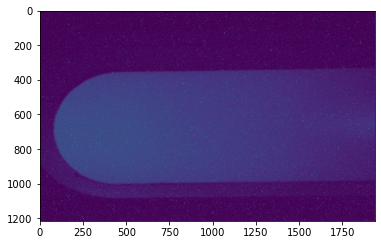

In [11]:
plt.imshow(spec1)

In [12]:
spec2, protons1, rif1, laser_value1, screens1 = load_all_event_data(Date,event_files[963],spectro_no=2,threshold=1750000)

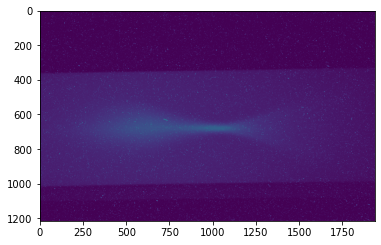

In [13]:
plt.imshow(spec2)

In [14]:
spec3, protons1, rif1, laser_value1, screens1 = load_all_event_data(Date,event_files[963],spectro_no=3,threshold=1750000)

In [15]:
spec4, protons1, rif1, laser_value1, screens1 = load_all_event_data(Date,event_files[963],spectro_no=4,threshold=1750000)

In [16]:
spec5, protons1, rif1, laser_value1, screens1 = load_all_event_data(Date,event_files[963],spectro_no=5,threshold=1750000)

In [17]:
spec6, protons1, rif1, laser_value1, screens1 = load_all_event_data(Date,event_files[963],spectro_no=6,threshold=1750000)

In [18]:
spec7, protons1, rif1, laser_value1, screens1 = load_all_event_data(Date,event_files[963],spectro_no=7,threshold=1750000)

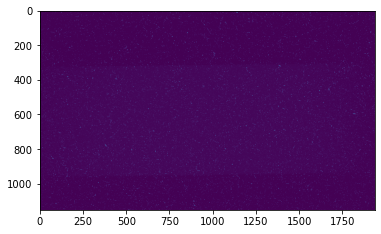

In [40]:
plt.imshow(spec6)

In [24]:
list_images = [spec1,spec2,spec3,spec4,spec5,spec6,spec7]

In [39]:
np.shape(spec6)

(1152, 1936)

In [41]:
#np.arange(1,8,1)

array([1, 2, 3, 4, 5, 6, 7])

In [81]:
images_for_stitch = []
for i in np.arange(1,8,1):
    
    spec, protons, rif, laser_valu, screens = load_all_event_data(Date,event_files[1193],spectro_no=i,threshold=1750000)
    images_for_stitch.append(spec)
    print(np.shape(spec))


images_for_stitch = [img.astype(float) for img in images_for_stitch]

(1216, 1936)
(1216, 1936)
(1216, 1936)
(1216, 1936)
(1216, 1936)
(1216, 1936)
(1216, 1936)


In [82]:
def bin_image2(img1, shape, interp=cv.INTER_AREA):
    return cv.resize(
            img1, 
            dsize=(shape[1], shape[0]),
            fx=0, fy=0,
            interpolation=interp
        )#*np.sqrt(np.prod(img1.shape)*np.prod(shape))

In [83]:
bin_factor = 2
sROI = [182*2, 910*2, 61*2, 11870*2]

stitched_image = stitch_images(images_for_stitch)

stitched_image = stitched_image[
    sROI[0]//bin_factor:sROI[1]//bin_factor,
    sROI[2]//bin_factor:sROI[3]//bin_factor
]

#mask = bin_image2(mask.astype(np.float32), stitched_image.shape).astype(bool)
#stitched_image[~mask] = 0

1.6488095238095237
1.9485930735930737
1.9485930735930737
2.783704390847248
2.165103415103415
2.783704390847248


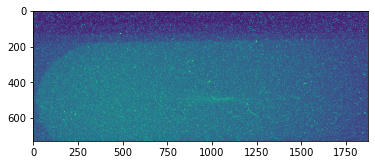

In [84]:
plt.imshow(stitched_image,vmax=800)